In [5]:
# This notebook implements the examples from Lagaris 
# ["Lux", "NeuralPDE", "Zygote", "ModelingToolkit", "OrdinaryDiffEq", "LineSearches", "ProgressMeter", "Gnuplot", "Optimization", "OptimizationOptimJL", "OptimizationOptimisers"]
using Lux, NeuralPDE, Zygote
using ModelingToolkit
using ModelingToolkit: Interval
using OrdinaryDiffEq
using LineSearches
using ProgressMeter
using Gnuplot
#gpexec("load '~/gpconfig.cfg'")
import Base.show # this is needed otherwise the next line just defines a new function in a new module
show(io::IO, ::MIME"text/html", gp::Gnuplot.GPSession) = Gnuplot._show(io, gp, "svg enhanced standalone mouse size 400,250")
Gnuplot.options.verbose = false;
dump(Gnuplot.options) # print out the options

# https://julialang.slack.com/archives/C690QRAA3/p1711534935292689
# What is the relationship between Optimization.jl and Optimisers.jl?
# Optimization.jl is an interface over a whole set of optimization packages. It's the level of DifferentialEquations.jl, NonlinearSolve.jl, LinearSolve.jl, interfacing to tons (>10?) optimization packages.
# Optimisers.jl is a specific library of optimizers. Optimisers.jl is a specific library of optimizers.
# Optimization.jl has a wrapper for using Optimisers.jl methods (OptimizationOptimisers.jl), and that's the most common way things are trained with SciML applications like Neural ODEs.
# Optim.jl (OptimizationOptimJL.jl) is another Julia package implementing various algorithms to perform univariate and multivariate optimization
using Optimization, OptimizationOptimJL, OptimizationOptimisers
using Random, Statistics

Gnuplot.Options
  dry: Bool false
  cmd: String "gnuplot"
  default: Symbol default
  term: String "unknown "
  gpviewer: Bool false
  init: Array{String}((0,))
  verbose: Bool false
  preferred_format: Symbol auto


Problem 1: A first order ODE 
$$
\frac{d} {d x} \Psi+( x+\frac{1+3 x^{2}} {1+x+x^{3}} ) \Psi=x^{3}+2 x+x^{2} \frac{1+3 x^{2}} {1+x+x^{3}} 
$$
with initial conditions $\Psi(0) = 1$, dependent variable $x$ with domain $x \in [0, 1]$.


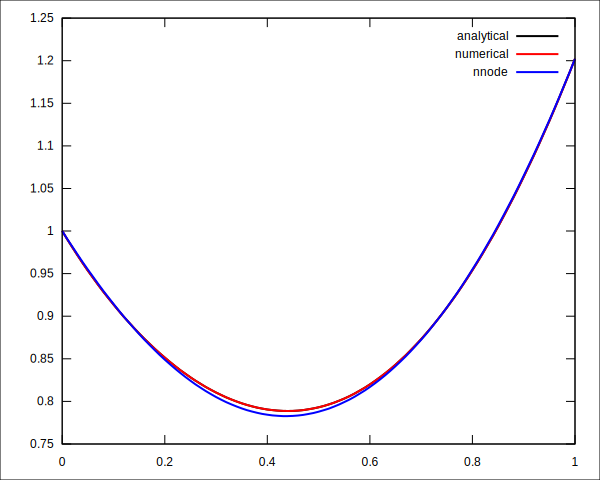

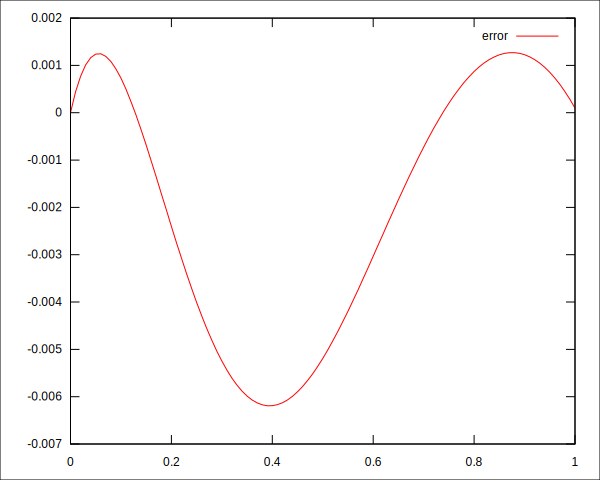

In [7]:
# Let's solve the following simple, linear ODE to get a sense of how to use the package 
analytical(t) = exp((-t^2)/(2))/(1 + t + t^3) + t^2
linear(u, p, t) = -(t + (1 + 3*t^2)/(1 + t + t^3))*u + t^3 + 2*t + t^2*((1 + 3*t^2)/(1 + t + t^3))
tspan = (0.0, 1.0)
u0 = 1
prob = ODEProblem(linear, u0, tspan) # we can of course solve this with traditional diffeq solvers
sol = solve(prob, Tsit5(), saveat = 0.01)
ground_truth = analytical.(sol.t)

# Let's the NNODE API to also solve this 
rng = Random.default_rng()
Random.seed!(rng, 0)
chain = Chain(Dense(1, 6, σ), Dense(6, 1)) # create a 2 layer, 5 neuron NN
ps, st = Lux.setup(rng, chain) |> Lux.f64 
opt = OptimizationOptimisers.Adam(0.1) # set up the optimiser 
alg = NNODE(chain, opt, init_params = ps, strategy=GridTraining(0.1))
nn = solve(prob, alg, verbose = false, maxiters = 500, saveat = 0.01)

@gp "reset" 
@gp :- sol.t ground_truth "with lines title 'analytical' lc 'black' lw 2"
@gp :- sol.t sol.u "with lines title 'numerical' lc 'red' lw 2"
@gp :- nn.t nn.u "with lines title 'nnode' lc 'blue' lw 2"
display(@gp)

@gp "reset"
@gp :- sol.t (nn.u .- ground_truth) "with lines title 'error' lc 'red'"

# System of Equations and Parameter Estimation. 
---- 

Can we estimate parameters of a system? Consider the Lorenz system: 
$$
\begin{aligned} 
    x' &= \sigma (y - x) \\
    y' &= x (\rho - z) - y \\
    z' &= xy - \beta z
\end{aligned}
$$
with parameter values $\sigma = 10.0, \rho = 28.0, \beta = \frac{8}{3}$

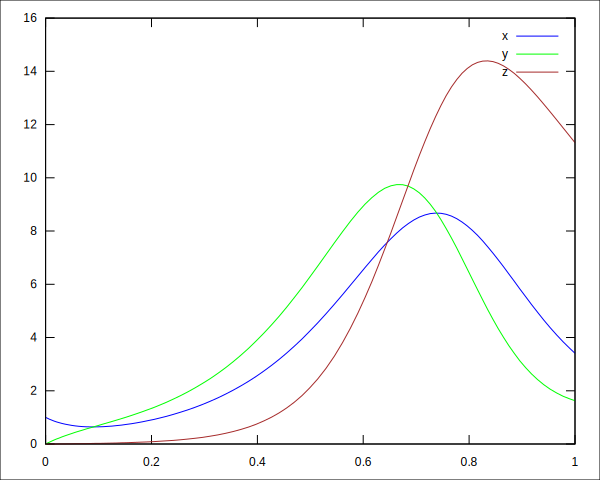

In [104]:
# Use MTK to set up the model
@parameters t, σ_, β, ρ
@variables x(..), y(..), z(..)
Dt = Differential(t) # set up the differential operator
eqs = [Dt(x(t)) ~ σ_ * (y(t) - x(t)),
       Dt(y(t)) ~ x(t) * (ρ - z(t)) - y(t),
       Dt(z(t)) ~ x(t) * y(t) - β * z(t)]

bcs = [x(0) ~ 1.0, y(0) ~ 0.0, z(0) ~ 0.0]
domains = [t ∈ Interval(0.0, 1.0)] # this is an array because it would contain the domains of all dependent parameters for mutlivariate functions
dt = 0.01

# Let's solve this system using regular numerical solver
# Remember the goal here is to estimate parameters
@mtkbuild c = ODESystem(eqs, t)
u0 = [c.x => 1.0, c.y => 0.0, c.z => 0.0]
#prob = ODEProblem(c, u0, (0.0, 1.0), [10.0, 28.0, 8 / 3])
prob = ODEProblem(c, u0, (0.0, 1.0), [10.0, 28.0, 8/3])
sol_numerical = solve(prob, Tsit5(), reltol = 1e-8, abstol = 1e-8) # uses the numerical solver algorithm
@gp "reset"
@gp :- sol_numerical.t sol_numerical[1, :] "with lines title 'x' lc 'blue'"
@gp :- sol_numerical.t sol_numerical[2, :] "with lines title 'y' lc 'green'"
@gp :- sol_numerical.t sol_numerical[3, :] "with lines title 'z' lc 'brown'"
display(@gp)

# we need to get the solutions out of the `sol_numerical` object to use in the additional_loss function
# for some reason, there are tons of errors if you try to directly use `sol_numerical` in the additional loss function
# although u_[[1], :] == Matrix(sol_numerical(ts)[1, :]')
# so I have no idea why
ts = [infimum(d.domain):0.01:supremum(d.domain) for d in domains][1]
function getData(sol)
    data = []
    us = hcat(sol(ts).u...)
    ts_ = hcat(sol(ts).t...)
    return [us, ts_]
end
data = getData(sol_numerical)
(u_, t_) = data
len = length(data[2])
display(u_)
display(u_[[1], :]) # the object that goes in the additional loss function


In [122]:
# let's solve with PINN API to do the forward simulation
# We can't use the NNODE API because of the way we've deinfed the ODE (i.e. using MTK)
# i.e., running
# alg = NNODE(chain, opt, init_params = ps, strategy=GridTraining(0.1))
# nn = solve(prob, alg, verbose = false, maxiters = 500, saveat = 0.01)
# returns error: The NNODE solver only supports out-of-place ODE definitions, i.e. du=f(u,p,t).

rng = Random.default_rng()
Random.seed!(rng, 0)
input_ = length(domains)
n = 8
chain1 = Lux.Chain(Dense(input_, n, Lux.σ), Dense(n, n, Lux.σ), Dense(n, n, Lux.σ), Dense(n, 1))
chain2 = Lux.Chain(Dense(input_, n, Lux.σ), Dense(n, n, Lux.σ), Dense(n, n, Lux.σ), Dense(n, 1))
chain3 = Lux.Chain(Dense(input_, n, Lux.σ), Dense(n, n, Lux.σ), Dense(n, n, Lux.σ), Dense(n, 1))
display(chain1)

# additional data
# additional data
#depvars = [:x, :y, :z]
depvars = [:x, :y, :z]

function additional_loss(phi, θ, p)
    return sum(sum(abs2, phi[i](t_, θ[depvars[i]]) .- u_[[i], :]) / len for i in 1:1:3)
end


# BUG: when `param_estim` is false, the trial solution θ sent to additional_loss is a different componentarray
    # with param_estim = false
    # the typeof(θ) is ComponentArrays.ComponentVector{Float64, Vector{Float64}, Tuple{ComponentArrays.Axis{(depvar = ViewAxis(1:507, Axis(x = ViewAxis(1:169, Axis(layer_1 = ViewAxis(1:16, Axis(weight = ViewAxis(1:8, ShapedAxis((8, 1))), bias = ViewAxis(9:16, ShapedAxis((8, 1))))), layer_2 = ViewAxis(17:88, Axis(weight = ViewAxis(1:64, ShapedAxis((8, 8))), bias = ViewAxis(65:72, ShapedAxis((8, 1))))), layer_3 = ViewAxis(89:160, Axis(weight = ViewAxis(1:64, ShapedAxis((8, 8))), bias = ViewAxis(65:72, ShapedAxis((8, 1))))), layer_4 = ViewAxis(161:169, Axis(weight = ViewAxis(1:8, ShapedAxis((1, 8))), bias = ViewAxis(9:9, ShapedAxis((1, 1))))))), y = ViewAxis(170:338, Axis(layer_1 = ViewAxis(1:16, Axis(weight = ViewAxis(1:8, ShapedAxis((8, 1))), bias = ViewAxis(9:16, ShapedAxis((8, 1))))), layer_2 = ViewAxis(17:88, Axis(weight = ViewAxis(1:64, ShapedAxis((8, 8))), bias = ViewAxis(65:72, ShapedAxis((8, 1))))), layer_3 = ViewAxis(89:160, Axis(weight = ViewAxis(1:64, ShapedAxis((8, 8))), bias = ViewAxis(65:72, ShapedAxis((8, 1))))), layer_4 = ViewAxis(161:169, Axis(weight = ViewAxis(1:8, ShapedAxis((1, 8))), bias = ViewAxis(9:9, ShapedAxis((1, 1))))))), z = ViewAxis(339:507, Axis(layer_1 = ViewAxis(1:16, Axis(weight = ViewAxis(1:8, ShapedAxis((8, 1))), bias = ViewAxis(9:16, ShapedAxis((8, 1))))), layer_2 = ViewAxis(17:88, Axis(weight = ViewAxis(1:64, ShapedAxis((8, 8))), bias = ViewAxis(65:72, ShapedAxis((8, 1))))), layer_3 = ViewAxis(89:160, Axis(weight = ViewAxis(1:64, ShapedAxis((8, 8))), bias = ViewAxis(65:72, ShapedAxis((8, 1))))), layer_4 = ViewAxis(161:169, Axis(weight = ViewAxis(1:8, ShapedAxis((1, 8))), bias = ViewAxis(9:9, ShapedAxis((1, 1))))))))),)}}}
    # or another way to see this is: for (i,key) in enumerate(keys(θ));  println("$(key): $(θ[key])"); end
    # which prints the structure: depvar: (x = (layer_1 = (weight =

    # with param_estim = true
    # the typeof is  ComponentArrays.ComponentVector{Float64, SubArray{Float64, 1, Vector{Float64}, Tuple{UnitRange{Int64}}, true}, Tuple{ComponentArrays.Axis{(x = ViewAxis(1:169, Axis(layer_1 = ViewAxis(1:16, Axis(weight = ViewAxis(1:8, ShapedAxis((8, 1))), bias = ViewAxis(9:16, ShapedAxis((8, 1))))), layer_2 = ViewAxis(17:88, Axis(weight = ViewAxis(1:64, ShapedAxis((8, 8))), bias = ViewAxis(65:72, ShapedAxis((8, 1))))), layer_3 = ViewAxis(89:160, Axis(weight = ViewAxis(1:64, ShapedAxis((8, 8))), bias = ViewAxis(65:72, ShapedAxis((8, 1))))), layer_4 = ViewAxis(161:169, Axis(weight = ViewAxis(1:8, ShapedAxis((1, 8))), bias = ViewAxis(9:9, ShapedAxis((1, 1))))))), y = ViewAxis(170:338, Axis(layer_1 = ViewAxis(1:16, Axis(weight = ViewAxis(1:8, ShapedAxis((8, 1))), bias = ViewAxis(9:16, ShapedAxis((8, 1))))), layer_2 = ViewAxis(17:88, Axis(weight = ViewAxis(1:64, ShapedAxis((8, 8))), bias = ViewAxis(65:72, ShapedAxis((8, 1))))), layer_3 = ViewAxis(89:160, Axis(weight = ViewAxis(1:64, ShapedAxis((8, 8))), bias = ViewAxis(65:72, ShapedAxis((8, 1))))), layer_4 = ViewAxis(161:169, Axis(weight = ViewAxis(1:8, ShapedAxis((1, 8))), bias = ViewAxis(9:9, ShapedAxis((1, 1))))))), z = ViewAxis(339:507, Axis(layer_1 = ViewAxis(1:16, Axis(weight = ViewAxis(1:8, ShapedAxis((8, 1))), bias = ViewAxis(9:16, ShapedAxis((8, 1))))), layer_2 = ViewAxis(17:88, Axis(weight = ViewAxis(1:64, ShapedAxis((8, 8))), bias = ViewAxis(65:72, ShapedAxis((8, 1))))), layer_3 = ViewAxis(89:160, Axis(weight = ViewAxis(1:64, ShapedAxis((8, 8))), bias = ViewAxis(65:72, ShapedAxis((8, 1))))), layer_4 = ViewAxis(161:169, Axis(weight = ViewAxis(1:8, ShapedAxis((1, 8))), bias = ViewAxis(9:9, ShapedAxis((1, 1))))))))}}}
    # or another way to see this is
    # x: (layer_1 = (weight = [-0.023238683119416237; -0.1539921909570694; -0.7880147695541382; -0.7045617699623108; -0.48987463116645813; 0.5913735032081604; -0.37440362572669983; -0.676106870174408;;], bias = [0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0;;]), layer_2 = (weight = [-0.10847090929746628 -0.4813615381717682 0.3334943354129791 0.4345085322856903 -0.3429463505744934 -0.4447147846221924 -0.3713844120502472 0.1545187383890152; -0.5760616660118103 -0.09771538525819778 0.16075554490089417 -0.5956249833106995 0.2189592570066452 -0.1198900118470192 0.15231120586395264 0.27584022283554077; 0.49248194694519043 -0.14765173196792603 -0.197963148355484 -0.27202215790748596 0.20187321305274963 -0.5808277726173401 0.3968111574649811 0.10379289090633392; 0.3024420440196991 0.27002885937690735 -0.4939984381198883 0.42284831404685974 0.4117656648159027 -0.12676578760147095 0.188303142786026 0.4382072389125824; -0.33438757061958313 0.12473965436220169 0.388154536485672 -0.07285594195127487 0.07992012798786163 0.2039923369884491 -0.5479699969291687 0.34157052636146545; 0.3022680878639221 -0.0772598460316658 0.24251185357570648 0.003908372949808836 0.03830299153923988 -0.2988305687904358 0.5001883506774902 -0.2905069589614868; -0.2530770003795624 0.4977363646030426 5.402036094892537e-6 -0.1630910485982895 0.26824861764907837 0.40895938873291016 -0.3514590263366699 -0.24365350604057312; 0.5837989449501038 0.04086669534444809 -0.03642717003822327 -0.6007563471794128 -0.39390501379966736 -0.4760797619819641 0.085951067507267 0.1896464228630066], bias = [0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0;;]), layer_3 = (weight = [0.29132479429244995 -0.26775744557380676 0.38854631781578064 -0.39073196053504944 0.17951323091983795 0.45733577013015747 0.47263726592063904 -0.032903727144002914; 0.19061441719532013 -0.4578108787536621 0.16938820481300354 0.4930223524570465 0.2606712877750397 0.6109293103218079 -0.5626375079154968 -0.26510170102119446; -0.10782763361930847 0.02851209230720997 0.4511156380176544 0.47337260842323303 0.1201501116156578 0.0008338845218531787 -0.40693536400794983 0.16438286006450653; 0.33639535307884216 -0.06269457191228867 0.3335040211677551 -0.2475416511297226 -0.4247908592224121 0.3513246178627014 0.32153069972991943 0.0642864927649498; 0.5022406578063965 0.15302829444408417 -0.18954385817050934 -0.5947675108909607 0.09007807075977325 0.268989622592926 0.4640932083129883 0.022478235885500908; 0.34504929184913635 -0.12962214648723602 0.5368787050247192 0.22780129313468933 0.008633475750684738 0.0719275251030922 0.24959106743335724 -0.5559582114219666; -0.602654218673706 0.3491476774215698 -0.5930685997009277 -0.3096136748790741 -0.39895540475845337 -0.3183773159980774 -0.1269359439611435 0.4579516053199768; 0.06782606244087219 0.06458907574415207 0.38842543959617615 0.5811533331871033 0.18213394284248352 -0.1381906419992447 5.7378380006412044e-5 -0.44280940294265747], bias = [0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0;;]), layer_4 = (weight = [0.45449918508529663 0.6072895526885986 0.5527653098106384 -0.23617146909236908 0.2771952152252197 0.03920525312423706 0.1190854012966156 -0.35941070318222046], bias = [0.0;;]))

    # so the bug is that with param_estim == false,  you have to do θ.depvar.x, θ.depvar.y, and so on for your dependent variables
    # but for param_estim == true, you have to do θ.x, θ.y
function additional_loss_as(phi, θ, p)
    # bug fix
    if p == nothing
      xp = θ.depvar[:x]
      yp = θ.depvar[:y]
      zp = θ.depvar[:z]
    else
      xp = θ[:x]
      yp = θ[:y]
      zp = θ[:z]
    end

    xloss = sum(abs2, phi[1](t_, xp) .- u_[[1], :]) / len
    yloss = sum(abs2, phi[2](t_, yp) .- u_[[2], :]) / len
    zloss = sum(abs2, phi[3](t_, zp) .- u_[[3], :]) / len
    xloss + yloss + zloss
end

strategy = NeuralPDE.QuadratureTraining(; abstol = 1e-6, reltol = 1e-6, batch = 100)
#strategy = NeuralPDE.GridTraining(0.0001)
#strategy = NeuralPDE.QuasiRandomTraining(200)

discretization = NeuralPDE.PhysicsInformedNN([chain1, chain2, chain3], strategy, param_estim=false, additional_loss=additional_loss_as)
@named pdesystem = PDESystem(eqs, bcs, domains, [t], [x(t), y(t), z(t)],  [σ_, ρ, β], defaults = Dict([σ_ => 10.0, ρ => 28.0, β => 8/3]))
prob = discretize(pdesystem, discretization)

opt = BFGS(linesearch = BackTracking())
#opt = OptimizationOptimisers.Adam(0.01) # set up the optimiser
res = Optimization.solve(prob, opt; maxiters = 2000)
display(res.retcode)

#ts = [infimum(d.domain):(0.001):supremum(d.domain) for d in domains][1]

#display(Dict([p .=> 1.0 for p in [σ_, ρ, β]]))
#display(Dict([σ_ .=> 10.0, ρ .=> 28.0, β .=> 8/3]))

retcode: Failure
u: ComponentVector{Float64}(depvar = (x = (layer_1 = (weight = [2.686268523879213; -3.986897876485868; … ; 4.392447463880739; -0.271619348473974;;], bias = [-0.572146242253783; 2.1157922916088556; … ; -4.053128102411815; -0.79510256109271;;]), layer_2 = (weight = [-0.7865673165681276 3.1097331483915234 … 0.10880217389535153 1.7218223047896457; 1.9408976690332205 1.4646494669011394 … -1.1251644291880563 -2.396761449653135; … ; 2.1605816662404016 -4.344457833249918 … -0.36701790910531196 2.660528935590876; -1.9953485629076053 -3.725750368299872 … -2.6049684815146277 4.972093154168666], bias = [-0.8165158648790812; -1.062338057221448; … ; -3.54069927815783; 0.3502791273333996;;]), layer_3 = (weight = [-0.693302182213492 -1.210260724202508 … 1.634335867551524 2.432777391018236; -0.8366731907174628 -1.8230182345387635 … -1.9487982636669405 -1.1316260657342614; … ; -0.7101548487560109 -4.501378898737146 … 2.1555834382190904 6.243741803524373; 0.5715651097581415 2.28042365537

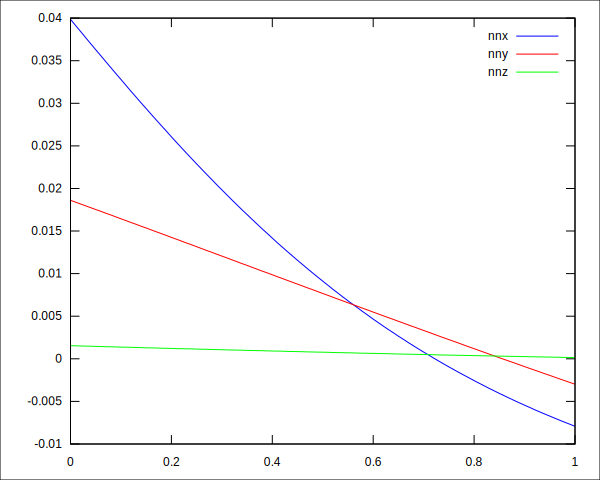

In [120]:
minimizers = [res.u.depvar[depvars[i]] for i in 1:3]
ts = [infimum(d.domain):dt:supremum(d.domain) for d in domains][1]
u_predict = [[discretization.phi[i]([t], minimizers[i])[1] for t in ts] for i in 1:3]
@gp "reset"
@gp :- ts u_predict[1] "with lines title 'nnx'"
@gp :- ts u_predict[2] "with lines title 'nny'"
@gp :- ts u_predict[3] "with lines title 'nnz'"

In [173]:
using Pkg
Pkg.status()


Status `~/pinns_in_julia/Project.toml`
  [0c46a032] DifferentialEquations v7.13.0
  [dc211083] Gnuplot v1.6.5
  [d3d80556] LineSearches v7.2.0
⌃ [b2108857] Lux v0.5.42
  [961ee093] ModelingToolkit v9.13.0
  [315f7962] NeuralPDE v5.16.0
  [3bd65402] Optimisers v0.3.3
  [7f7a1694] Optimization v3.24.3
  [36348300] OptimizationOptimJL v0.2.3
  [42dfb2eb] OptimizationOptimisers v0.2.1
  [1dea7af3] OrdinaryDiffEq v6.75.0
  [e88e6eb3] Zygote v0.6.70
Info Packages marked with ⌃ have new versions available and may be upgradable.
